# Ozone retrieval
For this exercise we will download a dataset of $O_3$ concentration from the TROPOMI instrument on board the Copernicus Sentinel-5p satellite. The dataset can be donloaded from the [Copernicus Dataspace](https://dataspace.copernicus.eu/). In order to download the dataset we have to select an areao of interest, the dates, and the product. From the menu we select: Sentinel-5p -> TROPOMI -> Level-2 O3. The tool can show us the available products. After the download we can use [Panoply](https://www.giss.nasa.gov/tools/panoply/) to have a look at the structure of the dataset.  

In [33]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import matplotlib.colors as mcol
from matplotlib.colors import ListedColormap
from zipfile import ZipFile
import netCDF4 as nc4
from zipfile import ZipFile

In [6]:
path = 'data/S5P_NRTI_L2_O3_20240818/'
filename = 'S5P_NRTI_L2_O3_20240818.nc'

The L2_O3 dataset is structured into two groups at the root level: PRODUCT and METADATA. The ozone total vertical column is in the PRODUCT group. The PRODUCT group contains a sub groups SUPPORT_DATA that itself contains three more sub groups: DETAILED_RESULTS, GEOLOCATIONS, and INPUT_DATA. The averaging kernel is in DETAILED_RESULTS

In [34]:
from netCDF4 import Dataset
fh = Dataset(path + filename, mode='r')
fh.groups

{'PRODUCT': <class 'netCDF4._netCDF4.Group'>
 group /PRODUCT:
     dimensions(sizes): scanline(357), ground_pixel(450), time(1), corner(4), layer(13), level(14)
     variables(dimensions): int32 scanline(scanline), int32 ground_pixel(ground_pixel), int32 time(time), int32 corner(corner), float32 latitude(time, scanline, ground_pixel), float32 longitude(time, scanline, ground_pixel), int32 delta_time(time, scanline, ground_pixel), <class 'str'> time_utc(time, scanline), uint8 qa_value(time, scanline, ground_pixel), float32 ozone_total_vertical_column(time, scanline, ground_pixel), float32 ozone_total_vertical_column_precision(time, scanline, ground_pixel), int32 layer(layer), int32 level(level)
     groups: SUPPORT_DATA,
 'METADATA': <class 'netCDF4._netCDF4.Group'>
 group /METADATA:
     dimensions(sizes): 
     variables(dimensions): 
     groups: EOP_METADATA, ISO_METADATA, QA_STATISTICS, GRANULE_DESCRIPTION, ESA_METADATA}

In [70]:
bb_north = 50.4687
bb_south = 42.0917
bb_west = -5.4580
bb_east = 7.4794
area_of_interest = [bb_north, bb_west, bb_south, bb_east]

## Ozone total vertical column

In [96]:
o3_product_ds = xr.open_dataset(path + filename, group='PRODUCT')
o3_product_ds

<xarray.Dataset>
Dimensions:                                (scanline: 357, ground_pixel: 450,
                                            time: 1, corner: 4, layer: 13,
                                            level: 14)
Coordinates:
  * scanline                               (scanline) float64 0.0 1.0 ... 356.0
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * time                                   (time) datetime64[ns] 2024-08-18
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) int32 0 1 2 3 ... 9 10 11 12
  * level                                  (level) int32 0 1 2 3 ... 10 11 12 13
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object ...
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...

In [97]:
latitude = o3_product_ds['latitude'].sel(time='2024-08-18')
latitude

<xarray.DataArray 'latitude' (scanline: 357, ground_pixel: 450)>
[160650 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 3.0 ... 353.0 354.0 355.0 356.0
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2024-08-18
Attributes:
    long_name:      pixel center latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/latitude_bounds

In [90]:
longitude = o3_product_ds['longitude'].sel(time='2024-08-18')
longitude

<xarray.DataArray 'longitude' (scanline: 357, ground_pixel: 450)>
array([[  0.538909,   0.626609,   0.7132  , ...,  29.938972,  30.043718,
         30.149845],
       [  0.515525,   0.603256,   0.689877, ...,  29.934229,  30.03905 ,
         30.145254],
       [  0.492087,   0.579848,   0.6665  , ...,  29.929457,  30.034355,
         30.140636],
       ...,
       [-10.547454, -10.446616, -10.346932, ...,  28.990053,  29.137112,
         29.286043],
       [-10.589358, -10.488484, -10.388765, ...,  28.990467,  29.13771 ,
         29.28683 ],
       [-10.631394, -10.530484, -10.43073 , ...,  28.99097 ,  29.138403,
         29.28771 ]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 3.0 ... 353.0 354.0 355.0 356.0
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2024-08-18
Attributes:
    long_name:      pixel center longitude
    units:          degrees_east
    standard_name:  longitude
    valid_min:      -180.0
    valid_max:      180.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/longitude_bounds

The variable *ozone_total_vertical_column* does not have latitude and longitude

In [98]:
o3_total_column = o3_product_ds['ozone_total_vertical_column'].sel(time='2024-08-18')
o3_total_column

<xarray.DataArray 'ozone_total_vertical_column' (scanline: 357,
                                                 ground_pixel: 450)>
[160650 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 3.0 ... 353.0 354.0 355.0 356.0
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2024-08-18
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             total ozone column
    multiplication_factor_to_convert_to_DU:                2241.15
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214e+19

In [99]:
conversion_factor = o3_total_column.multiplication_factor_to_convert_to_molecules_percm2
conversion_factor

6.02214e+19

In [100]:
o3_total_column_converted = o3_total_column * conversion_factor
o3_total_column_converted

<xarray.DataArray 'ozone_total_vertical_column' (scanline: 357,
                                                 ground_pixel: 450)>
array([[          nan, 7.9012461e+18, 7.9286218e+18, ..., 8.4069148e+18,
        8.2488221e+18, 8.3381387e+18],
       [          nan, 7.8688875e+18, 7.9331952e+18, ..., 8.4591043e+18,
        8.4118253e+18, 8.4000869e+18],
       [          nan, 7.8494652e+18, 7.9529391e+18, ..., 8.4479250e+18,
        8.3398782e+18, 8.2681614e+18],
       ...,
       [          nan, 8.6295423e+18, 8.6284406e+18, ..., 8.2428023e+18,
        8.2971605e+18, 8.1719069e+18],
       [          nan, 8.6273823e+18, 8.6582154e+18, ..., 8.1622944e+18,
        8.2266257e+18, 8.0727249e+18],
       [          nan, 8.6078627e+18, 8.6599301e+18, ..., 8.1694181e+18,
        8.1123590e+18, 8.1133551e+18]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 3.0 ... 353.0 354.0 355.0 356.0
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2024-08-18

In [68]:
def create_figure(): 
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.coastlines()
    ax.set_extent([bb_west, bb_east, bb_south, bb_north], ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    return fig, ax

Text(0.5, 1.0, 'O3 total vertical column - 2024-08-18')

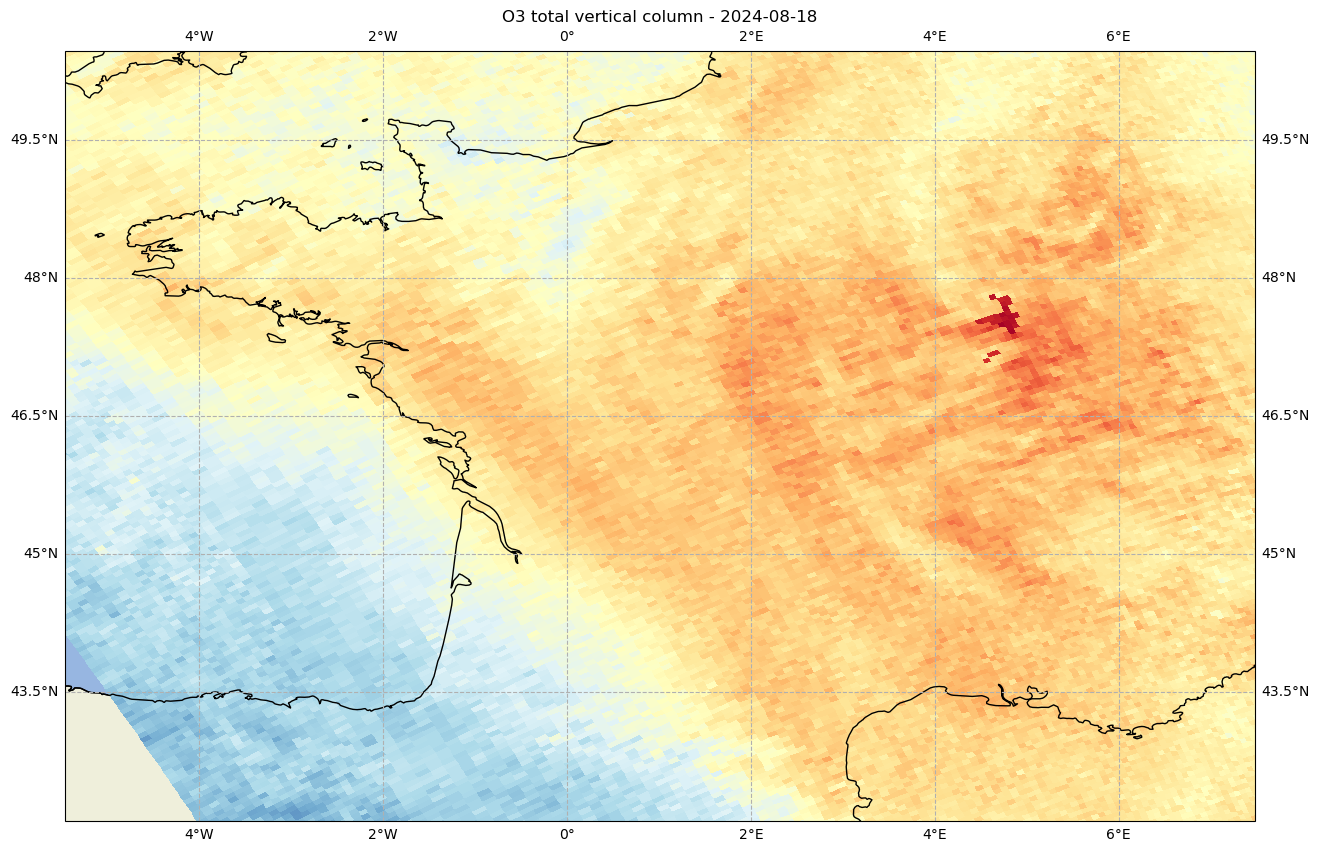

In [102]:
_, ax = create_figure()
plt.pcolormesh(longitude, 
               latitude, 
               o3_total_column_converted,
               cmap='RdYlBu_r',
               shading='auto',
               transform=ccrs.PlateCarree())
plt.title('O3 total vertical column - 2024-08-18')

## Averaging kernel

In [37]:
o3_support_ds = xr.open_dataset(path + filename, group='PRODUCT/SUPPORT_DATA/DETAILED_RESULTS')
o3_support_ds

<xarray.Dataset>
Dimensions:                                 (time: 1, scanline: 357,
                                             ground_pixel: 450, layer: 13,
                                             level: 14,
                                             number_of_slant_columns: 4,
                                             number_of_doas_polynomial_coefficients: 4)
Coordinates:
  * number_of_slant_columns                 (number_of_slant_columns) int32 0...
  * number_of_doas_polynomial_coefficients  (number_of_doas_polynomial_coefficients) int32 ...
Dimensions without coordinates: time, scanline, ground_pixel, layer, level
Data variables: (12/25)
    ozone_profile_apriori                   (time, scanline, ground_pixel, layer) float32 ...
    averaging_kernel                        (time, scanline, ground_pixel, layer) float32 ...
    pressure_grid                           (time, scanline, ground_pixel, level) float32 ...
    fitted_slant_columns                    (time, scanline, ground_pixel, number_of_slant_columns) float64 ...
    fitted_slant_columns_precision          (time, scanline, ground_pixel, number_of_slant_columns) float32 ...
    number_of_iterations_slant_column       (time, scanline, ground_pixel) float32 ...
    ...                                      ...
    number_of_iterations_vertical_column    (time, scanline, ground_pixel) float32 ...
    effective_scene_albedo                  (time, scanline, ground_pixel) float32 ...
    effective_scene_albedo_precision        (time, scanline, ground_pixel) float32 ...
    doas_polynomial_coefficients            (time, scanline, ground_pixel, number_of_doas_polynomial_coefficients) float32 ...
    euv                                     (time, scanline, ground_pixel) float32 ...
    processing_quality_flags                (time, scanline, ground_pixel) float64 ...

In [117]:
o3_averaging_kernel = o3_support_ds['averaging_kernel']
o3_averaging_kernel.shape
o3_averaging_kernel

<xarray.DataArray 'averaging_kernel' (time: 1, scanline: 357,
                                      ground_pixel: 450, layer: 13)>
array([[[[     nan, ...,      nan],
         ...,
         [0.273834, ..., 1.063437]],

        ...,

        [[     nan, ...,      nan],
         ...,
         [0.259664, ..., 1.060363]]]], dtype=float32)
Dimensions without coordinates: time, scanline, ground_pixel, layer
Attributes:
    units:      1
    long_name:  ozone averaging kernel
    positive:   up

Text(0.5, 1.0, '$O_3$ Averagingg kernel layer 0- 2024-08-18')

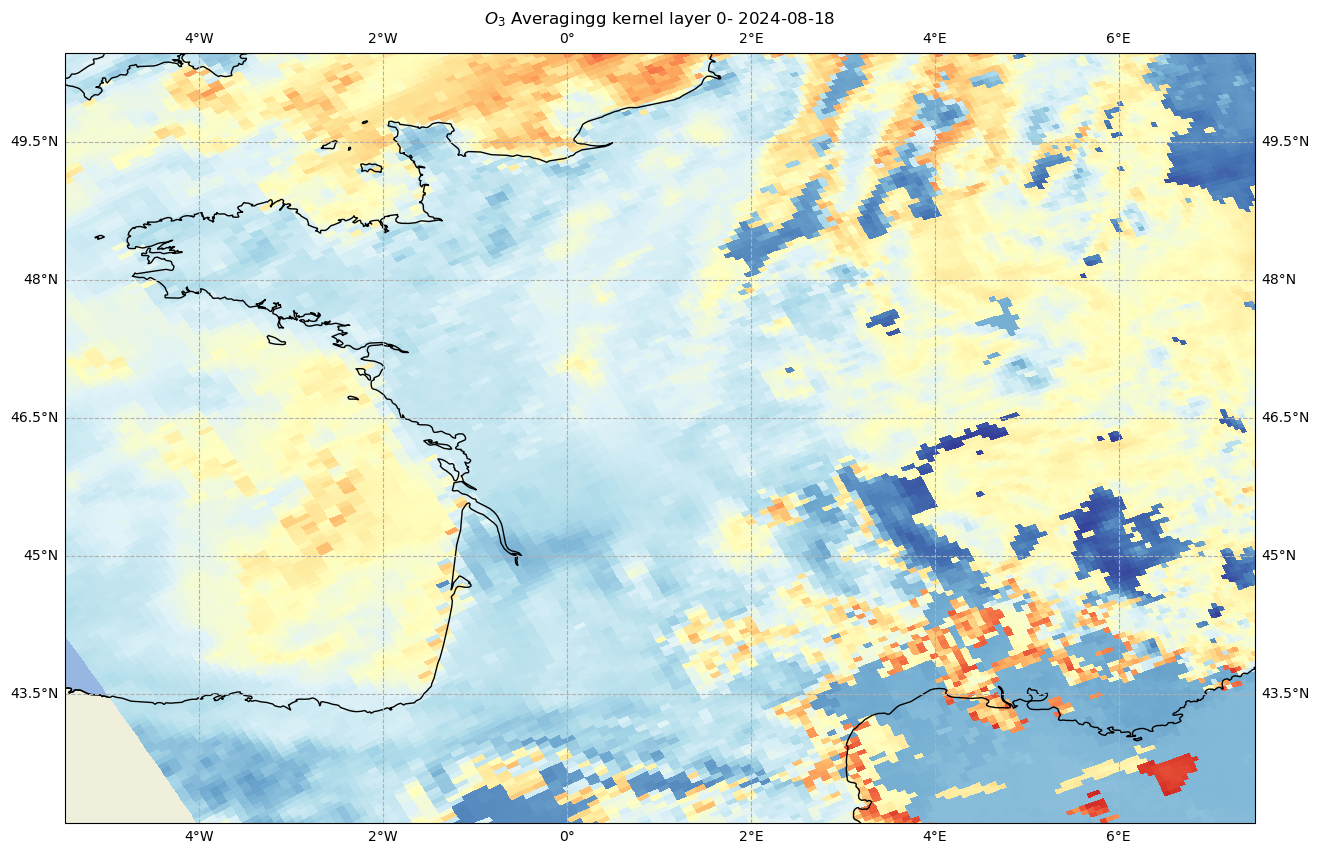

In [120]:
layer = 0
time = 0
_, ax = create_figure()
plt.pcolormesh(longitude, 
               latitude, 
               o3_averaging_kernel[time,:,:,layer],
               cmap='RdYlBu_r',
               shading='auto',
               transform=ccrs.PlateCarree())
plt.title('$O_3$ Averagingg kernel layer {:d}- 2024-08-18'.format(layer))

## CAMS 3D Ozone Field
We download the ozone data for the selected area and dates from the [Copernicus Atmosphere Monitoring Service](https://ads-beta.atmosphere.copernicus.eu/datasets/cams-global-atmospheric-composition-forecasts?tab=overview). We retrieve all the pressure levels above the same area covered in the Sentinel-5p data and the same time window. 

In [24]:
DATADIR = 'data/CAMS'
start_date = '2024-08-18'
end_date = '2024-08-18'
WDIR = f'cams_3d_global_{start_date}_{end_date}'

In [25]:
import cdsapi

dataset = "cams-global-atmospheric-composition-forecasts"
request = {
    'variable': ['ozone'],
    'pressure_level': ['1', '2', '3', '5', '7', '10', '20', '30', '50', '70', '100', '150', '200', '250', '300', '400', '500', '600', '700', '800', '850', '900', '925', '950', '1000'],
    'date': [f'{start_date}/{end_date}'],
    'time': ['00:00'],
    'leadtime_hour': ['0', '3', '6', '9', '12', '15', '18', '21', '24'],
    'type': ['forecast'],
    'data_format': 'netcdf_zip',
    'area': [50.4687, -5.458, 42.0917, 7.4794]
}

In [26]:
client = cdsapi.Client()
client.retrieve(dataset, request).download()

2024-08-20 10:22:38,652 INFO Welcome to the CDS
2024-08-20 10:22:38,655 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2024-08-20 10:22:38,700 INFO Request is queued
2024-08-20 10:22:39,732 INFO Request is running
2024-08-20 10:22:46,937 INFO Request is completed
2024-08-20 10:22:46,938 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data0/adaptor.mars_constrained.internal-1724142164.775677-22359-1-c8f76f54-3e99-473d-8690-b9b3481c823d.grib to adaptor.mars_constrained.internal-1724142164.775677-22359-1-c8f76f54-3e99-473d-8690-b9b3481c823d.grib (480.3K)
2024-08-20 10:22:49,069 INFO Download rate 225.3K/s


'adaptor.mars_constrained.internal-1724142164.775677-22359-1-c8f76f54-3e99-473d-8690-b9b3481c823d.grib'

In [27]:
with ZipFile(f'{DATADIR}/{WDIR}.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/{WDIR}/')

In [28]:
cams_o3_ds = xr.open_dataset(f'{DATADIR}/{WDIR}/data_plev.nc') 
cams_o3_ds

<xarray.Dataset>
Dimensions:                  (forecast_period: 9, forecast_reference_time: 1,
                              pressure_level: 25, latitude: 21, longitude: 33)
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 00:00:00 ... 1...
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 2024-08-18
  * pressure_level           (pressure_level) float64 1e+03 950.0 ... 2.0 1.0
  * latitude                 (latitude) float64 50.09 49.69 ... 42.49 42.09
  * longitude                (longitude) float64 -5.458 -5.058 ... 6.942 7.342
    valid_time               (forecast_reference_time, forecast_period) datetime64[ns] ...
Data variables:
    go3                      (forecast_period, forecast_reference_time, pressure_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-08-20T08:35 GRIB to CDM+CF via cfgrib-0.9.1...

In [31]:
cams_o3 = cams_o3_ds['go3'].sel(forecast_reference_time='2024-08-18')
cams_o3

<xarray.DataArray 'go3' (forecast_period: 9, pressure_level: 25, latitude: 21,
                         longitude: 33)>
[155925 values with dtype=float32]
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 00:00:00 ... 1...
    forecast_reference_time  datetime64[ns] 2024-08-18
  * pressure_level           (pressure_level) float64 1e+03 950.0 ... 2.0 1.0
  * latitude                 (latitude) float64 50.09 49.69 ... 42.49 42.09
  * longitude                (longitude) float64 -5.458 -5.058 ... 6.942 7.342
    valid_time               (forecast_period) datetime64[ns] ...
Attributes: (12/32)
    GRIB_paramId:                             210203
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      693
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               kg kg**-1
    long_name:                                Ozone mass mixing ratio (full c...
    units:                                    kg kg**-1
    standard_name:                            mass_fraction_of_ozone_in_air
    GRIB_number:                              0

In [48]:
cams_o3.forecast_period

<xarray.DataArray 'forecast_period' (forecast_period: 9)>
array([             0, 10800000000000, 21600000000000, 32400000000000,
       43200000000000, 54000000000000, 64800000000000, 75600000000000,
       86400000000000], dtype='timedelta64[ns]')
Coordinates:
  * forecast_period          (forecast_period) timedelta64[ns] 00:00:00 ... 1...
    forecast_reference_time  datetime64[ns] 2024-08-18
    valid_time               (forecast_period) datetime64[ns] ...
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

In [57]:
delta_time = 3 * 60 * 60 * 10**9 # delta between one lead time and the next one
num_forecasts = 25
start_day = pd.to_datetime(start_date)
date_index = start_day + pd.to_timedelta(np.arange(num_forecasts, step=3), 'h')
date_index.size
start_day.strftime('%Y-%m-%d %H:%M:%S')

'2024-08-18 00:00:00'

In [58]:
date_index

DatetimeIndex(['2024-08-18 00:00:00', '2024-08-18 03:00:00',
               '2024-08-18 06:00:00', '2024-08-18 09:00:00',
               '2024-08-18 12:00:00', '2024-08-18 15:00:00',
               '2024-08-18 18:00:00', '2024-08-18 21:00:00',
               '2024-08-19 00:00:00'],
              dtype='datetime64[ns]', freq=None)

In [65]:
cams_o3_assigned = cams_o3.assign_coords(forecast_period=date_index)
cams_o3_assigned

<xarray.DataArray 'go3' (forecast_period: 9, pressure_level: 25, latitude: 21,
                         longitude: 33)>
[155925 values with dtype=float32]
Coordinates:
    forecast_reference_time  datetime64[ns] 2024-08-18
  * pressure_level           (pressure_level) float64 1e+03 950.0 ... 2.0 1.0
  * latitude                 (latitude) float64 50.09 49.69 ... 42.49 42.09
  * longitude                (longitude) float64 -5.458 -5.058 ... 6.942 7.342
    valid_time               (forecast_period) datetime64[ns] ...
  * forecast_period          (forecast_period) datetime64[ns] 2024-08-18 ... ...
Attributes: (12/32)
    GRIB_paramId:                             210203
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      693
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               kg kg**-1
    long_name:                                Ozone mass mixing ratio (full c...
    units:                                    kg kg**-1
    standard_name:                            mass_fraction_of_ozone_in_air
    GRIB_number:                              0

In [66]:
cams_o3_assigned.sel(forecast_period='2024-08-18 03:00:00')

<xarray.DataArray 'go3' (pressure_level: 25, latitude: 21, longitude: 33)>
[17325 values with dtype=float32]
Coordinates:
    forecast_reference_time  datetime64[ns] 2024-08-18
  * pressure_level           (pressure_level) float64 1e+03 950.0 ... 2.0 1.0
  * latitude                 (latitude) float64 50.09 49.69 ... 42.49 42.09
  * longitude                (longitude) float64 -5.458 -5.058 ... 6.942 7.342
    valid_time               datetime64[ns] ...
    forecast_period          datetime64[ns] 2024-08-18T03:00:00
Attributes: (12/32)
    GRIB_paramId:                             210203
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      693
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               kg kg**-1
    long_name:                                Ozone mass mixing ratio (full c...
    units:                                    kg kg**-1
    standard_name:                            mass_fraction_of_ozone_in_air
    GRIB_number:                              0

Text(0.5, 1.0, 'CAMS $O_3$ - 2024-08-18 plev=1000')

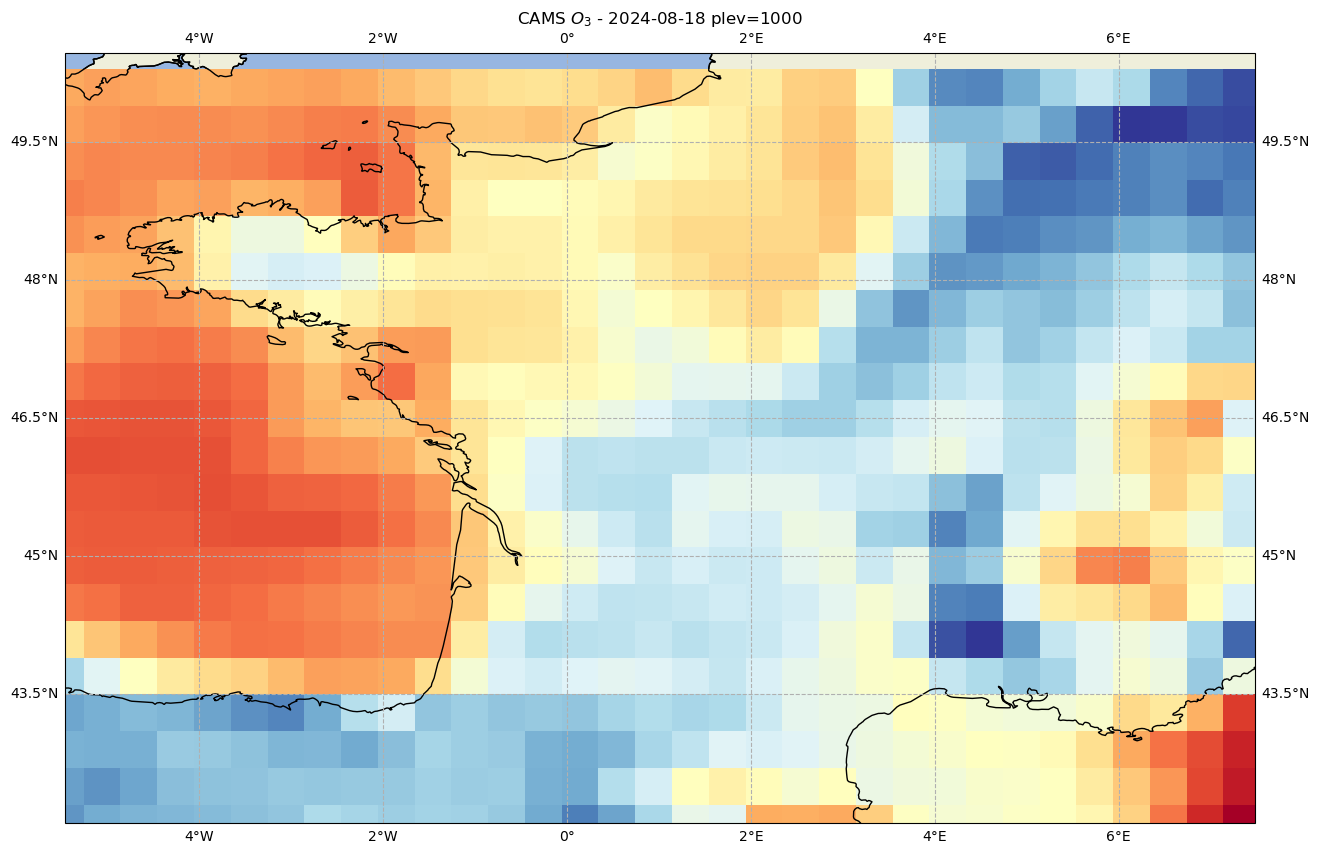

In [74]:
_, ax = create_figure()
plt.pcolormesh(cams_o3_assigned.longitude, 
               cams_o3_assigned.latitude, 
               cams_o3_assigned.sel(forecast_period='2024-08-18 03:00:00', pressure_level=1000),
               cmap='RdYlBu_r',
               shading='auto',
               transform=ccrs.PlateCarree())
plt.title('CAMS $O_3$ - 2024-08-18 plev=1000')

## References
* [Eskes, Boersma - Averaging kernels for DOAS total-column satellite retrievals](https://acp.copernicus.org/articles/3/1285/2003/acp-3-1285-2003.html)
* [Rodgers - Inverse methods for atmospheric sounding - Theory and practice](https://acp.copernicus.org/articles/3/1285/2003/acp-3-1285-2003.html))